<a href="https://colab.research.google.com/github/EmilGauti/flog/blob/master/flog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import warnings
warnings.filterwarnings("ignore")



1.1.   (klára/laga features) reikna auðkenni á minni tímabútum og skeyta því saman í lengri auðkennavigur 

1.2.   prófa fleiri flokkara (svm, tré), tuna parametra, prófa með basic test-train á öllum gögnum

1.3.   Fá út accuracy, sens og spec (ruglingsfylki) (kannski matthews líka?)



2.1.   Klára patient specific skriftu (kasta út acc, spec og sens á alla og svo meðaltal)

2.2.   Keyra hana með besta (eða öllum) flokkaranum



3.1.   Fourier myndadót eins og í grein úr pósti

3.2.   Tauganet á það



4.1   (Vega mikilvægi features ef við notum tré)

In [14]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#input: 
#filename: name of file to read from
#shape: dimension of resulting array                   
def read3DArrayFromFile(fileName,shape):                      
    data = np.loadtxt(fileName, dtype = 'float32')
    data = data.reshape(shape)
    return(data)

nrPatients = 24
fs = 256 # Sampling rate
nrChannels = 23
seizureLength = 14 # seconds
nrSeizures = 170
fRange = 129
M = 16
fLowerLimit = 0.5
fUpperLimit = 25
dataShape = (nrSeizures,nrChannels,seizureLength*fs)

# Read raw data
seizureData = read3DArrayFromFile('seizureChunks14.txt',dataShape)
nonSeizureData = read3DArrayFromFile('nonSeizureChunks14.txt',dataShape)
allData = np.concatenate((seizureData,nonSeizureData),axis = 0)

In [61]:
# Calculate EEG features
[X,y] = create_data_matrix(allData, nrSeizures, nrChannels, fRange, fs, M, fLowerLimit, fUpperLimit, hjorth = True)
print("X:", X.shape)
print("y:", y.shape)

print('Logistic Regression classifier trained on data from pooled subjects')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
###################################################
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

La = linear_model.Lasso()
Et = ExtraTreesRegressor(n_jobs=-1, n_estimators=500)
Rf = RandomForestRegressor(n_jobs=-1, n_estimators=500)
Gbt = GradientBoostingRegressor()
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3))#kannski má ekki vera max_depth>1
clf_tree = DecisionTreeClassifier(random_state=0)      
clf_svm = svm.SVC()
clf_LR=LogisticRegression(max_iter  = 200)


name = [La,Et,Rf,Gbt,clf_tree,clf_svm,clf_LR,clf_ada]
names_s = ['La','Et','Rf','Gbt','clf_tree', 'clf_svm', 'clf_LR', 'clf_ada']
for i in range(len(name)):
    name[i].fit(X_train,y_train)
    print(names_s[i]+' score:' , name[i].score(X_test,y_test))

X: (340, 437)
y: (340,)
Logistic Regression classifier trained on data from pooled subjects
La score: 0.062273806040411994
Et score: 0.6123183166109252
Rf score: 0.5167868450390187
Gbt score: 0.5771637081236465
clf_tree score: 0.6941176470588235
clf_svm score: 0.4588235294117647
clf_LR score: 0.5882352941176471
clf_ada score: 0.8823529411764706


Model sensitivity: 0.8913043478260869
Model specificity: 0.8974358974358975


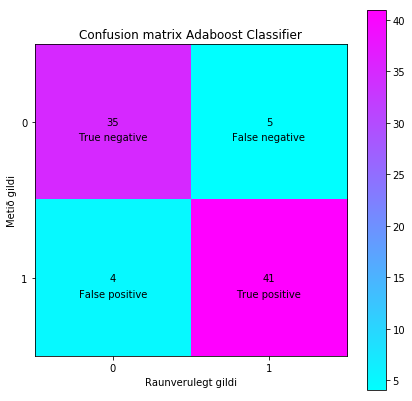

In [57]:
from sklearn import metrics
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(y_test,clf_ada.predict(X_test))
plt.figure(figsize=(7,7))
plt.imshow(cm, cmap='cool')
plt.title('Confusion matrix Adaboost Classifier')
plt.xlabel('Raunverulegt gildi')
plt.ylabel('Metið gildi')
plt.xticks([0,1])
plt.yticks([0,1])
plt.colorbar()
n = cm.shape[0]
p = cm.shape[1]
blabb = ['True negative','False positive','False negative','True positive']
ind=0
for i in range(n):
    for j in range(p):        
        plt.annotate(str(cm[i,j]),xy=(i,j), 
                     horizontalalignment='center', verticalalignment='center')
        plt.annotate(blabb[ind],xy=(i,j+0.1), horizontalalignment='center'
                     , verticalalignment='center')
        ind=ind+1
sens = cm[1,1]/(cm[1,1] + cm[1,0])
spec = cm[0,0]/(cm[0,0] + cm[0,1])

print('Model sensitivity:', sens)
print('Model specificity:', spec)

In [8]:
# FEATURES

import numpy as np
from scipy import signal

# Hjorth parameters (time domain)
# https://en.wikipedia.org/wiki/Hjorth_parameters
def hjorth_mobility(x):
    num = np.var(np.diff(x))
    den = np.var(x)
    if den > 0:
        return np.sqrt(num / den)
    else:
        return 0.0

def hjorth_parameters(x):
    activity=np.var(x)
    mobility=hjorth_mobility(x)
    if mobility > 0:
        complexity=hjorth_mobility(np.diff(x)) / mobility
    else:
        complexity=0.0
    return np.array([activity, mobility, complexity])

#Calculates power spectral density for an eeg segment
#inputs: 
#signalMat: signal matrix for chunk
#fs: sampling density
#n: number of channels
#outputs: 
#f: frequency
#Pwelch: power spectral density calculated by Welch's method
def psd(signalMat,fs,n,fRange):
    Pwelch = np.zeros((n,fRange))
    for i in range(n):
        F,Pwelch[i,:] = signal.welch(signalMat[i,:],fs,scaling = 'spectrum')
    return(F,Pwelch)

# Absolute band power
# Combined power in M frequency bands
def absolute_power(f, PSD,M,l,h):
    length = (h-l)/M
    power = []
    k = l
    for i in range(M):
        power.append(sum(PSD[np.where((f > k) & (f <= k+length))]))
        k +=length
    return(power)
    
#Relative power of delta, theta, alpha 
#and beta waves for a single channel
def relative_power(f,PSD,M,l,h):
    absPow = absolute_power(f,PSD,M,l,h)
    tot = sum(PSD)
    if tot > 0.0:
        return(absPow/tot)
    else:
        return 0.0

# Calculate relative band power for the whole data set
# THINK: Might want to do the same for absolute power
def relative_power_all(allData, nrSeizures, nrChannels, fRange, fs, M, fLowerLimit, fUpperLimit):
    dataPSD = np.zeros((nrSeizures*2,nrChannels,fRange))
    for i in range(nrSeizures*2):
        [F,dataPSD[i,:,:]] = psd(allData[i,:,:],fs,nrChannels,fRange)

    dataRelPower = np.zeros((nrSeizures*2,nrChannels,M))
    for i in range(nrSeizures*2):
        for j in range(nrChannels):
            dataRelPower[i,j,:] = relative_power(F,dataPSD[i,j,:],M,fLowerLimit,fUpperLimit)
    return(dataRelPower)
    
def create_data_matrix(allData, nrSeizures, nrChannels, fRange, fs, M, fLowerLimit, fUpperLimit, hjorth = True):
    dataRelPower = relative_power_all(allData, nrSeizures, nrChannels, fRange, fs, M, fLowerLimit, fUpperLimit)
      
    dataRelPowerFlat = np.zeros((nrSeizures*2,M*nrChannels))
    for i in range(nrSeizures*2):
        dataRelPowerFlat[i,:] = dataRelPower[i,:,:].flatten()
        
    if hjorth:
        hjopar = np.zeros((nrSeizures*2,nrChannels,3))
        for i in range(nrSeizures*2):
            for j in range(nrChannels):
                hjopar[i,j,:] = hjorth_parameters(allData[i,j,:])

        hjoparflat = np.zeros((nrSeizures*2,nrChannels*3))
        for i in range(nrSeizures*2):
            hjoparflat[i,:] = hjopar[i,:,:].flatten()
        dataRelPowerFlat = np.c_[dataRelPowerFlat, hjoparflat]
    
    
    X = dataRelPowerFlat
    y = np.concatenate((np.repeat(1,nrSeizures),np.repeat(0,nrSeizures)))
        
    return(X,y)


In [13]:
# PATIENT SPECIFIC

# -*- coding: utf-8 -*-

# Patient-specific classifier

# Pre: Execute main.py

import ast

def fixIndex(i):
    if i < 10:
        i = '0'+str(i)
    return(str(i))

nonSeizureFileNames = open('nonSeizureFileNames.txt', 'r')
nonSeizureFileNames = nonSeizureFileNames.read().split('\n')

with open('seizureDict.txt', 'r') as f:
    s = f.read()
    seizureDict = ast.literal_eval(s)

scores = np.zeros((nrPatients))

for testPatient in range(1,nrPatients+1):
    #gets index of seizures that belong to testPatient (+nrSeizures since seizure chunks are first in allData)
    prefix = 'chb'+fixIndex(testPatient)
    nonSeizIndices = [i+nrSeizures for i, s in enumerate(nonSeizureFileNames) if s.startswith(prefix)]
    testPatientKeys = [i for i in seizureDict.keys() if i.startswith(prefix)]
    k = 0
    seizIndices = []
    for key in seizureDict:    
        for i in range(len(seizureDict[key])):
            if key in testPatientKeys:
                seizIndices.append(k)
            k = k+1

    print("Patient ", testPatient, "n_seizures=",len(seizIndices), "n_nonseizures=",len(nonSeizIndices))
    
    X_test = np.concatenate((X[seizIndices,:],X[nonSeizIndices,:]),axis = 0)
    y_test = np.concatenate((y[seizIndices],y[nonSeizIndices]))
    X_train = np.delete(X, nonSeizIndices, axis=0)
    X_train = np.delete(X_train, seizIndices, axis=0)
    y_train = np.delete(y,nonSeizIndices)
    y_train = np.delete(y_train,seizIndices)
    # THINK: Collect statistics on seizure/nonseizure
    print("Train:", X_train.shape, "Test:", X_test.shape)

    # Classify individual patient
    # Insert code here ...
    clf=LogisticRegression(max_iter = 200)
    clf.fit(X_train, y_train)
    scores[testPatient-1] = clf.score(X_test, y_test)
    print("Accuracy: ", scores[testPatient-1])

print('Mean accuracy:', np.mean(scores))
#print('Accuracy Quantiles:', np.quantile(scores, q = [0, 0.25, 0.5, 0.75, 1]))

Patient  1 n_seizures= 7 n_nonseizures= 11
Train: (322, 437) Test: (18, 437)
Accuracy:  0.9444444444444444
Patient  2 n_seizures= 2 n_nonseizures= 15
Train: (323, 437) Test: (17, 437)
Accuracy:  0.7647058823529411
Patient  3 n_seizures= 7 n_nonseizures= 5
Train: (328, 437) Test: (12, 437)
Accuracy:  0.5833333333333334
Patient  4 n_seizures= 4 n_nonseizures= 14
Train: (322, 437) Test: (18, 437)
Accuracy:  0.6111111111111112
Patient  5 n_seizures= 4 n_nonseizures= 15
Train: (321, 437) Test: (19, 437)
Accuracy:  0.7894736842105263
Patient  6 n_seizures= 10 n_nonseizures= 3
Train: (327, 437) Test: (13, 437)
Accuracy:  0.38461538461538464
Patient  7 n_seizures= 3 n_nonseizures= 4
Train: (333, 437) Test: (7, 437)
Accuracy:  0.5714285714285714
Patient  8 n_seizures= 5 n_nonseizures= 5
Train: (330, 437) Test: (10, 437)
Accuracy:  0.9
Patient  9 n_seizures= 4 n_nonseizures= 4
Train: (332, 437) Test: (8, 437)
Accuracy:  1.0
Patient  10 n_seizures= 7 n_nonseizures= 9
Train: (324, 437) Test: (16, 

In [ ]:
print('Mean accuracy:', np.quantile(scores, 0.5))

AttributeError: ignored

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Dense#, Activation
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D
from tensorflow.python.keras.optimizers import Adadelta
from tensorflow.python.keras.callbacks import EarlyStopping

n,m,p = allData.shape
fr = np.zeros((n,m,p))
for i in range(n):
    for j in range(m):
        fr[i,j,:] = np.fft.fft(allData[i,j,:])
frFlat = np.zeros((n,m*p))
for i in range(n):
    frFlat[i,:] = fr[i,:,:].flatten()
# Calculate EEG features
X = fr
print("X:", X.shape)
print("y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
num_classes=1
num_epochs = 20
batch_sizeA=300
input_shape = X_train.shape[1:]

# set up early stopping
es = EarlyStopping(monitor='val_acc',
                   min_delta=0,
                   patience=2,
                   verbose=0, mode='auto')

modelA = Sequential([ 
    Conv1D(32, kernel_size=10, activation='relu', padding = "same", input_shape = input_shape),
    Conv1D(32, kernel_size=10, activation='relu', padding = "same"),
    MaxPooling1D(pool_size=5),
    Conv1D(64, kernel_size=10, activation='relu', padding = "same"),
    Conv1D(64, kernel_size=10, activation='relu', padding = "same"),
    MaxPooling1D(pool_size=5),
    Conv1D(128, kernel_size=10, activation='relu', padding = "same"),
    Conv1D(128, kernel_size=10, activation='relu', padding = "same"),
    Conv1D(128, kernel_size=10, activation='relu', padding = "same"),
    MaxPooling1D(pool_size=5),
    Flatten(),
    Dense(100, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid') ])

modelA.summary()

modelA.compile(loss='binary_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

historyA=modelA.fit(X_train, y_train,
                  batch_size=batch_sizeA,
                  epochs=num_epochs,
                 # callbacks = [es],
                  verbose=1,
                  validation_data=(X_test, y_test))
scoreA = modelA.evaluate(X_test, y_test, verbose=0)
print('val loss:', scoreA[0])
print('val accuracy:', scoreA[1])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


X: (340, 23, 3584)
y: (340,)
(255, 23, 3584)


ValueError: ignored